# 4.3 - Multiclass Classification With Reuters Dataset

* [4.3.1 - The Boston Housing Prices Dataset](#first-bullet)
* [4.3.2 - Preparing the Data](#second-bullet)
* [4.3.3 - Building Your Model](#third-bullet)
* [4.3.4 - Further Experiments](#fourth-bullet)

## 4.3.1 - The Boston Housing Prices Dataset <a class="anchor" id="first-bullet"></a>

The Reuters dataset has 46 classes with at least 10 examples per class.
The overall goal is to predict the median house prices of homes in a given Boston suburb in the mid 1970's.

Setup and data import:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import reuters
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Get the shape of the data set:

In [3]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


Our targets are median home values in thousands of dollars.  We'll show the first 10.

In [4]:
train_targets[0:9]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6])

## 4.3.2 - Preparing The Data <a class="anchor" id="second-bullet"></a>

Each feature of our training data has a different range, which can be problematic for training.  We will use feature-wide normalization as a best practice to overcome this issue by calculating the mean and standard deviation of each feature, subtracting each feature value by the mean, and dividing by the standard deviation.

Training data before:

In [7]:
train_data

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, ..., 2.10000e+01,
        3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, ..., 1.47000e+01,
        3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, ..., 2.02000e+01,
        3.75520e+02, 3.26000e+00],
       ...,
       [3.46600e-02, 3.50000e+01, 6.06000e+00, ..., 1.69000e+01,
        3.62250e+02, 7.83000e+00],
       [2.14918e+00, 0.00000e+00, 1.95800e+01, ..., 1.47000e+01,
        2.61950e+02, 1.57900e+01],
       [1.43900e-02, 6.00000e+01, 2.93000e+00, ..., 1.56000e+01,
        3.76700e+02, 4.38000e+00]])

In [8]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Training data after:

In [9]:
train_data

array([[-0.27224633, -0.48361547, -0.43576161, ...,  1.14850044,
         0.44807713,  0.8252202 ],
       [-0.40342651,  2.99178419, -1.33391162, ..., -1.71818909,
         0.43190599, -1.32920239],
       [ 0.1249402 , -0.48361547,  1.0283258 , ...,  0.78447637,
         0.22061726, -1.30850006],
       ...,
       [-0.40202987,  0.99079651, -0.7415148 , ..., -0.71712291,
         0.07943894, -0.67776904],
       [-0.17292018, -0.48361547,  1.24588095, ..., -1.71818909,
        -0.98764362,  0.42083466],
       [-0.40422614,  2.04394792, -1.20161456, ..., -1.30866202,
         0.23317118, -1.15392266]])

We will use a smaller model to help prevent against overfitting.

Note that the final layer does not have an activation function; the final layer is a linear layer.

In [10]:
def build_model():
    model = keras.Sequential([
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
    ])
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Since we have so little data, we are using K-fold validation.  The data is partitioned into K folds, K-1 partitions of the data are used for training the model, and the remaining partition is used for validation.  The model is built and evaluated K times, and the average scores of all K models are used to evaluate model performance.

In [14]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #%d' % i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


The mean average error for each K models, and the average MAE for all K models are below:

In [15]:
print(all_scores)
print(np.mean(all_scores))

[4.269517421722412, 2.9482357501983643, 3.094834804534912, 3.541163682937622]
3.4634379148483276


Our performance isn't great, what if we increase the number of training epochs from 100 to 500?

In [16]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #%d' % i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold #0
processing fold #1
processing fold #2
processing fold #3


And then calculate the per-epoch MAE for all K folds.

In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Plot the validation MAE versus number of epochs used to train the model:

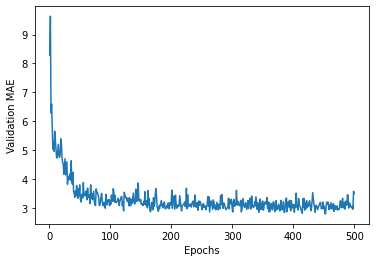

In [18]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Same plot, but removing the first 20 data points and plot points as an exponential moving average to smooth out the curve:

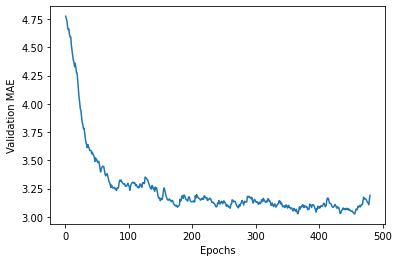

In [23]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[20:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Interestingly, my MAE seems to level out, but the MAE shown in the text decreases until epoch 80 and then steadily increases.  The same models are used, so I'm not sure what would account for the difference.